In [1]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import create_fake_data as cr
reload(cr)
sys.path.append('../code_general_Finkelsteinlab')
import plotting_Finkelsteinlab as pltData
reload(pltData);
from scipy.optimize import curve_fit

model_ID = 'Clv_Saturated_general_energies_v2'
times = [0.0,12.0,60.0,180.0,600.0,1800.0,6000.0,18000.0,60000.0]
guide = 20

path_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

### Show result of fit

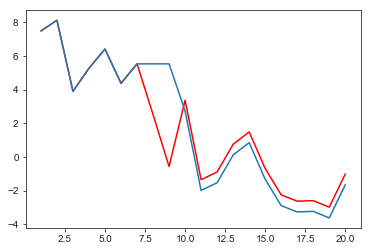

In [17]:
filename = 'fit_14_3_2019_sim_23.txt'
path = '../fits_Stijn/14_3_2019/'
data = pd.read_table(path+filename,index_col=False)
final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 42']
final_par_np = final_par.values
chi = data.loc[:,'Potential']
par1 = data.loc[:,'Parameter 4']
par2 = data.loc[:,'Parameter 7']
data.tail()

plt.plot(range(1,21),-np.cumsum(final_par_np[0:20]),'r')
final_par_np[7] = 0.0
final_par_np[8] = 0.0
final_par_np[9] = 2.8
#final_par_np[29] = 7.5
#final_par_np[30] = 6.0

plt.plot(range(1,21),-np.cumsum(final_par_np[0:20]))
#plt.legend(['fit','altered fit'])
#plt.title('Energy landscape')

### Comparing to Boyle Parameters

Text(0.5,1,'difference in parameters squared')

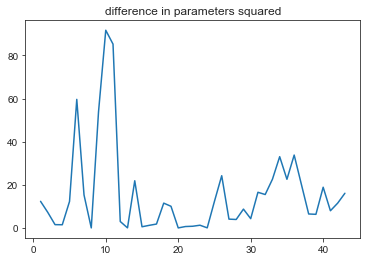

In [50]:
parameters = np.loadtxt('example-params-2.txt')
difference_sqrd = (parameters-final_par_np)**2
plt.figure
plt.plot(range(1,44),difference_sqrd)
plt.title('difference in parameters squared')

### Errorbars, weighted average kclv

In [4]:
filename = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_nucleaseq(filename,path_to_data)
_, ydatamedian, yerrmedian = processing.prepare_multiprocessing_nucleaseq(filename, path_to_data, True)

pos = []
kclv = []
error = []
kclvmedian = []
errormedian = []


i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(np.average(ydata[a], weights=np.reciprocal(yerr[a]) ))
            kclvmedian.append(ydatamedian[a][0])
            error.append(np.mean(yerr[a]))
            #error.append(np.std(ydata[a]))
            errormedian.append(yerrmedian[a][0])
            i = i + 1
    
pos.append(21)
kclv.append(np.average(ydata[0], weights=np.reciprocal(yerr[0])))
error.append(np.mean(yerr[0]))
kclvmedian.append(ydata[0][0])
errormedian.append(yerr[0][0])

pos = np.array(pos)
kclv = np.array(kclv)
error = np.array(error)
kclvmedian = np.array(kclvmedian)
errormedian = np.array(errormedian)

print errormedian/kclvmedian

[0.13749498 0.22110008 0.06301255 0.05214467 0.1123199  1.48406048
 1.6096799  0.11150093 0.06897429 0.12981053 0.11430685 0.11055873
 0.10968006 0.05985859 0.08290558 0.1211262  0.0438294  0.03571584
 0.03638285 0.03449434 0.38681251]


In [5]:
def f(x,a):
    return a


k_double = np.zeros([20,20])
for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = np.log10(np.average(ydata[a], weights=np.reciprocal(yerr[a])))
        #k_double[i-1,j-1] = np.log10(curve_fit(f,range(len(ydata[a])),ydata[a],10**(-3),yerr[a])[0])
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))


## Single mismatches

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 <a list of 7 Text yticklabel objects>)

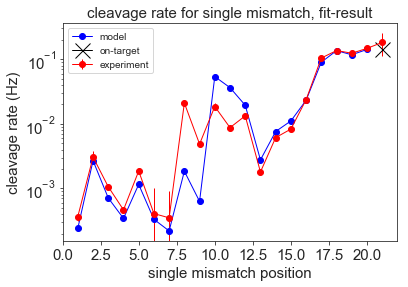

In [18]:
data_exp = pd.read_csv(path_data + filename_data)
k_exp_pd = pltData.plot_single_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, data_name='cleavage rate (Hz)', Plot=False, 
                                                    logplot=False, SaveFigures=False)
#k_exp = np.append(k_exp_pd.values[:,1],np.median(ydata[0]))
k_exp = k_exp_pd.values[:,1]

_, k_fake, _ = cr.create_fake_data()
k_fake = k_fake[1:21]

k = np.zeros(20)
for i in range(1,guide+1):
    mismatch = [i]
    k[i-1] = clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch,guide)
    
plt.figure
plt.semilogy(range(1,21),k, marker='o', linewidth=1, color='blue')
#plt.semilogy(range(1,21),k_exp, marker='o', linewidth=1, color='red')
plt.errorbar(pos,kclvmedian,errormedian, marker='o', linewidth=1, color='red')
plt.xlabel('single mismatch position', fontsize=15)
plt.ylabel('cleavage rate (Hz)', fontsize=15)
plt.title('cleavage rate for single mismatch, fit-result', fontsize=15)
plt.semilogy(21,clv.calc_clv_rate_fast(final_par_np,model_ID,[],guide),marker='x',markersize=15,linewidth=1,color='black') #ontarget
plt.legend(['model','on-target','experiment'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.axis([0,22,10**(-5),10**(-0.5)]);

## Double mismatches

Text(0.5,1,'double mismatches, top=model bottom=experiment')

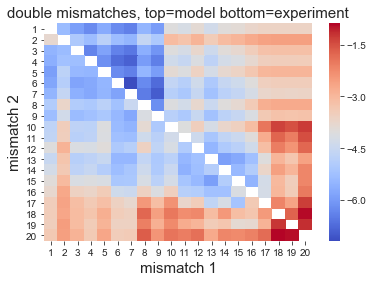

In [19]:
data_exp = pd.read_csv(path_data + filename_data)
_, k_matrix_experiment = pltData.plot_double_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, Ng=20, data_name='cleavage rate (Hz)', Plot=False, logplot=True,
                        SaveFigures=False, figure_name='./Figure.pdf')
k_matrix_experiment.fillna(0, inplace=True)

k_matrix = np.zeros([20,20])
#k_matrix_fake = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch_positions,guide))
        
#for i in range(1,20):
#    for j in range(i+1,21):
#        mismatch_positions = [i,j]
#        k_matrix_fake[j-1,i-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions,guide))
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
#k_df_fake = pd.DataFrame(k_matrix_fake, index=range(1, 21), columns=range(1, 21))
combined_df_wa = k_df + k_double_df
combined_df_median = k_df + k_matrix_experiment
#combined_df_fake = k_df + k_df_fake

for i in range(1,21):
    combined_df_wa[i].loc[i]=np.nan
    combined_df_median[i].loc[i]=np.nan
#    combined_df_fake[i].loc[i]=np.nan

sns.heatmap(combined_df_median, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('double mismatches, top=model bottom=experiment', fontsize=15)


## Chi squared evolution

(array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 8 Text yticklabel objects>)

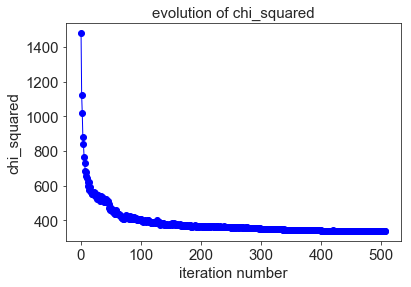

In [110]:
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

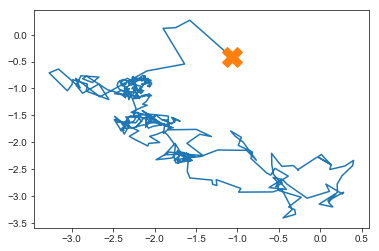

In [111]:
plt.plot(par1,par2)
plt.plot(par1[0],par2[0],marker='X',markersize=20)